<a href="https://colab.research.google.com/github/yanann11/nebius_llm_course/blob/main/topic1/1.6_llm_inference_parameters_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLMOps Essentials, practice 1.6. LLM Inference Parameters

# Practice Solutions

## Getting ready

In [ ]:
!pip install -q openai

In [ ]:
import os

with open("nebius_api_key", "r") as file:
    nebius_api_key = file.read().strip()

os.environ["NEBIUS_API_KEY"] = nebius_api_key

We'll be calling APIs quite often in this notebook, so let's define a shortcut fuction to avoid repeating all the code:

In [ ]:
from openai import OpenAI

nebius_client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)

llama_8b_model = "meta-llama/Meta-Llama-3.1-8B-Instruct"

def prettify_string(text, max_line_length=80):
    """Prints a string with line breaks at spaces to prevent horizontal scrolling.

    Args:
        text: The string to print.
        max_line_length: The maximum length of each line.
    """

    output_lines = []
    lines = text.split("\n")
    for line in lines:
        current_line = ""
        words = line.split()
        for word in words:
            if len(current_line) + len(word) + 1 <= max_line_length:
                current_line += word + " "
            else:
                output_lines.append(current_line.strip())
                current_line = word + " "
        output_lines.append(current_line.strip())  # Append the last line
    return "\n".join(output_lines)

def answer_with_llm(prompt: str,
                    system_prompt="You are a helpful assistant",
                    max_tokens=512,
                    client=nebius_client,
                    model=llama_8b_model,
                    prettify=True,
                    temperature=0.6,
                    top_p=None,
                    frequency_penalty=0) -> str:

    messages = []

    if system_prompt:
        messages.append(
            {
                "role": "system",
                "content": system_prompt
            }
        )

    messages.append(
        {
            "role": "user",
            "content": prompt
        }
    )

    completion = client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=max_tokens,
        temperature=temperature,
        top_p=top_p,
        frequency_penalty=frequency_penalty
    )

    if prettify:
        return prettify_string(completion.choices[0].message.content)
    else:
        return completion.choices[0].message.content

In [ ]:
nebius_client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)

def answer_with_logprobs(prompt: str,
                    system_prompt="You are a helpful assistant",
                    max_tokens=512,
                    temperature=0.6,
                    logprobs=True,
                    top_logprobs=5,
                    client=nebius_client,
                    model="meta-llama/Meta-Llama-3.1-8B-Instruct"):
    completion = nebius_client.chat.completions.create(
      model="meta-llama/Meta-Llama-3.1-8B-Instruct",
      messages=[
            {
                "role": "system",
                "content": system_prompt
            },
            {
                "role": "user",
                "content": prompt
            }
        ],
        temperature=temperature,
        logprobs=True,
        top_logprobs=5,
    )

    return completion

completion = answer_with_logprobs("""What is at the heart of every story?
                Answer in exactly six words""")
completion.choices[0].message.content

"A character's transformation or emotional growth."

In [ ]:
import pandas as pd

def logprobs_to_table(logprobs_content):
    '''
    Creates a pandas data frame showcasing:
    - The actually generated token with its log probability
    - The top tokens and their log probabilities
    '''
    generated_tokes = []
    generated_logprobs = []
    # At 0-th position in the logprobs_content[0].top_logprobs
    # there's always the actually generated token
    # We don't include it
    top_tokens = [[] for _ in range(len(logprobs_content[0].top_logprobs) - 1)]
    top_logprobs = [[] for _ in range(len(logprobs_content[0].top_logprobs) - 1)]
    for entry in logprobs_content:
        generated_tokes.append(entry.token)
        generated_logprobs.append(entry.logprob)

        for j, top_logprob in enumerate(entry.top_logprobs[1:]):
            top_tokens[j].append(top_logprob.token)
            top_logprobs[j].append(top_logprob.logprob)

    df = pd.DataFrame({
        "gen_token": generated_tokes,
        "gen_logp": generated_logprobs
    })
    for j in range(len(top_tokens)):
        df[f"{j}_token"] = top_tokens[j]
        df[f"{j}_logp"] = top_logprobs[j]
    return df

# Practice: exploring LLM parameters and creativity

## Task 1. Favourite names and occupations

In this task, you'll try to understand if LLMs have favourite fantasy names, occupations, and jobs. For that, we suggest you to:

* Choose several LLMs (for example, three Llamas-3.1 and Qwen2.5-32B-Instruct)
* For each, run `answer_with_llm` with `temperature=0.6` for `n_trials=20` times and prompts

  * `Suggest a name for a fantasy character. Only output the name.`
  * `Suggest an occupation for a fantasy character. Only output the name of the occupation.`
  * `Suggest a hobby for a fantasy character. Only output the name of the hobby.`

  Are there many different options? Is there a hope for an LLM-generated fantasy character to be a smith or a carpenter?..

* Repeat the experiment with `temperature=1`.

* Now, for each model and for each prompt, run `answer_with_logprobs` with `temperature=0.6`. Look at the predicted log probabilities. Do some of them dominate the distribution? (That is, are some of them significantly larger than the others?)

* Think about a way of generating more diverse names and occupations.

In [ ]:
# <YOUR EXPERIMENTS HERE>

**Solution** Let's start with some experiments.

In [ ]:
from tqdm import tqdm

n_trials = 20
prompts = [
    """Suggest a name for a fantasy character. Only output the name.""",
    """Suggest an occupation for a fantasy character. Only output the occupation name.""",
    """Suggest an hobby for a fantasy character. Only output the hobby name."""
]
models = [
    "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "meta-llama/Meta-Llama-3.1-70B-Instruct",
    "meta-llama/Meta-Llama-3.1-405B-Instruct",
    "Qwen/Qwen2.5-32B-Instruct"
]

results = {}

for model in models:
    for prompt in prompts:
        results[(model, prompt)] = []
        print(f"Processing:\n\tmodel: {model}\n\tprompt: {prompt}")
        for _ in tqdm(range(n_trials)):
            answer = answer_with_llm(prompt, model=model, temperature=0.6)
            results[(model, prompt)].append(answer)

Processing:
	model: meta-llama/Meta-Llama-3.1-8B-Instruct
	prompt: Suggest a name for a fantasy character. Only output the name.


100%|██████████| 20/20 [00:08<00:00,  2.49it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-8B-Instruct
	prompt: Suggest an occupation for a fantasy character. Only output the occupation name.


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-8B-Instruct
	prompt: Suggest an hobby for a fantasy character. Only output the hobby name.


100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-70B-Instruct
	prompt: Suggest a name for a fantasy character. Only output the name.


100%|██████████| 20/20 [00:08<00:00,  2.23it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-70B-Instruct
	prompt: Suggest an occupation for a fantasy character. Only output the occupation name.


100%|██████████| 20/20 [00:11<00:00,  1.68it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-70B-Instruct
	prompt: Suggest an hobby for a fantasy character. Only output the hobby name.


100%|██████████| 20/20 [00:09<00:00,  2.22it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-405B-Instruct
	prompt: Suggest a name for a fantasy character. Only output the name.


100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-405B-Instruct
	prompt: Suggest an occupation for a fantasy character. Only output the occupation name.


100%|██████████| 20/20 [00:07<00:00,  2.60it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-405B-Instruct
	prompt: Suggest an hobby for a fantasy character. Only output the hobby name.


100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Processing:
	model: Qwen/Qwen2.5-32B-Instruct
	prompt: Suggest a name for a fantasy character. Only output the name.


100%|██████████| 20/20 [00:47<00:00,  2.39s/it]


Processing:
	model: Qwen/Qwen2.5-32B-Instruct
	prompt: Suggest an occupation for a fantasy character. Only output the occupation name.


100%|██████████| 20/20 [01:01<00:00,  3.07s/it]


Processing:
	model: Qwen/Qwen2.5-32B-Instruct
	prompt: Suggest an hobby for a fantasy character. Only output the hobby name.


100%|██████████| 20/20 [00:56<00:00,  2.83s/it]


In [ ]:
from collections import Counter

for key, value in results.items():
    print(f"model = {key[0]}\nprompt = {key[1]}:\n")
    for k, v in Counter(value).items():
        print(f"\t{k}: {v}")
    print()

model = meta-llama/Meta-Llama-3.1-8B-Instruct
prompt = Suggest a name for a fantasy character. Only output the name.:

	Eira Shadowglow: 9
	Aethoniel Darkshadow: 1
	Kaelin Darkhaven: 3
	Kaelith Sunshadow: 4
	Eryndor Thorneblack: 1
	Kaelara Moonwhisper: 2

model = meta-llama/Meta-Llama-3.1-8B-Instruct
prompt = Suggest an occupation for a fantasy character. Only output the occupation name.:

	Dreamweaver: 1
	Luminari Weaver: 1
	Moonweaver: 1
	Moonwhisper Cartographer: 10
	Master Cartographer: 2
	Luminari Cartographer: 1
	Clockwork Engineer: 2
	Chronokeeper: 1
	Aeromancer: 1

model = meta-llama/Meta-Llama-3.1-8B-Instruct
prompt = Suggest an hobby for a fantasy character. Only output the hobby name.:

	Luminous Terracotta Crafting: 1
	Moonwhisper Illumination: 1
	Moonlit Botany: 3
	Luminous Cartography: 1
	Luminari Glassblowing: 1
	Crystalography: 1
	Luminari Gardening: 1
	Dreamweaving: 2
	Mythweaving: 2
	Clockwork Insect Collecting: 1
	Moonlight Cartomancy: 1
	Luminous Gardening: 2
	Lumin

As you see, names and occupations are very repetitive. For example, Llama-3.1-8B seems to adore the name Eira Shadowglow; Llama-3.1-405B loves Shawowweaving (whatever that could be...); and Qwen is fond of dragon taming.

At first glance, hobbies seem a little more diverse, but if you look closely, you'll see the same shadows and dragons, just with some additional details.

So, let's look at the log probabilities. We won't output them for all the models, only for Llama-3.1-8B:

In [ ]:
completion = answer_with_logprobs(
    """Create a name for a fantasy character. Only output the name.""",
    model="meta-llama/Meta-Llama-3.1-8B-Instruct",
    temperature=0.6)
completion.choices[0].message.content

'Eira Shadowglow'

In [ ]:
logprobs_to_table(completion.choices[0].logprobs.content)

,gen_token,gen_logp,0_token,0_logp,1_token,1_logp,2_token,2_logp,3_token,3_logp
0,E,-0.877382,K,-0.669081,Ly,-3.220751,A,-3.923761,Th,-4.496584
1,ira,-0.334373,ir,-1.740394,ly,-2.912078,ry,-3.016231,ri,-5.567897
2,Shadow,-0.021107,eth,-3.952759,F,-7.454794,L,-8.053654,Flynn,-8.092710
3,gl,-0.000049,leaf,-10.883694,g,-11.144070,gle,-12.107454,fire,-12.419903
4,ow,0.000000,ade,-19.528072,are,-21.845404,ows,-22.574451,OW,-22.873882
5,,-0.000019,.,-10.870647,en,-15.661533,<|eom_id|>,-16.039078,e,-17.249817


In [ ]:
completion = answer_with_logprobs(
    """Create an occupation for a fantasy character. Only output the occupation name.""",
    model="meta-llama/Meta-Llama-3.1-8B-Instruct",
    temperature=0.6)
completion.choices[0].message.content

'Dreamweaver'

In [ ]:
logprobs_to_table(completion.choices[0].logprobs.content)

,gen_token,gen_logp,0_token,0_logp,1_token,1_logp,2_token,2_logp,3_token,3_logp
0,Dream,-1.501330,Moon,-0.746245,L,-1.553404,Sky,-3.896773,Shadow,-4.000923
1,we,-0.040886,walker,-3.217453,w,-12.695078,catch,-14.231287,seek,-15.259766
2,aver,0.000000,ilder,-19.397884,ver,-19.892593,eper,-20.361267,avery,-20.829943
3,,-0.136773,of,-2.167693,.,-4.498044,Apprentice,-6.789336,for,-8.078189


In [ ]:
completion = answer_with_logprobs(
    """Suggest a hobby for a fantasy character. Only output the hobby name.""",
    model="meta-llama/Meta-Llama-3.1-70B-Instruct",
    temperature=0.6)
completion.choices[0].message.content

'Luminous Flower Arranging'

In [ ]:
logprobs_to_table(completion.choices[0].logprobs.content)

,gen_token,gen_logp,0_token,0_logp,1_token,1_logp,2_token,2_logp,3_token,3_logp
0,L,-0.784618,Moon,-1.565740,My,-1.721966,A,-3.232136,St,-3.909109
1,umin,-0.007116,um,-4.980264,unar,-9.276439,apid,-9.640964,ac,-10.890759
2,ous,-0.416527,ari,-1.093499,arium,-5.259488,we,-8.383981,arian,-9.529628
3,Flower,-7.991506,Cart,-1.143662,Glass,-1.169700,Gard,-1.664411,Bot,-2.862132
4,Arr,-0.197764,Press,-1.760010,arrangement,-5.457326,Gard,-6.902404,We,-7.097684
5,anging,-0.263823,angement,-1.461547,ang,-11.355769,anger,-13.230464,angling,-22.109228
6,,-0.004796,.,-5.342469,for,-16.421394,!,-16.473469,<|eom_id|>,-16.994217


You can see that with `temperature=0.6`:

- In names, `E` and `K` as starting tokens dominate everything else,
- Also, `Shadow` is a very likely start of the second name.
- In occupations, `Shadow`, `Moon`, and `L` are much more probable starting tokens than everything else.
- The same is true for hobbies and starting tokens `L`, `Moon`, `My`.

With `temperature=1`, it becomes a little bit better, although overall the diversity is still very low:

In [ ]:
results = {}

for model in models:
    for prompt in prompts:
        results[(model, prompt)] = []
        print(f"Processing:\n\tmodel: {model}\n\tprompt: {prompt}")
        for _ in tqdm(range(n_trials)):
            answer = answer_with_llm(prompt, model=model, temperature=1)
            results[(model, prompt)].append(answer)

Processing:
	model: meta-llama/Meta-Llama-3.1-8B-Instruct
	prompt: Suggest a name for a fantasy character. Only output the name.


100%|██████████| 20/20 [00:08<00:00,  2.31it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-8B-Instruct
	prompt: Suggest an occupation for a fantasy character. Only output the occupation name.


100%|██████████| 20/20 [00:09<00:00,  2.09it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-8B-Instruct
	prompt: Suggest an hobby for a fantasy character. Only output the hobby name.


100%|██████████| 20/20 [00:08<00:00,  2.39it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-70B-Instruct
	prompt: Suggest a name for a fantasy character. Only output the name.


100%|██████████| 20/20 [00:10<00:00,  1.94it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-70B-Instruct
	prompt: Suggest an occupation for a fantasy character. Only output the occupation name.


100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-70B-Instruct
	prompt: Suggest an hobby for a fantasy character. Only output the hobby name.


100%|██████████| 20/20 [00:08<00:00,  2.32it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-405B-Instruct
	prompt: Suggest a name for a fantasy character. Only output the name.


100%|██████████| 20/20 [00:11<00:00,  1.79it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-405B-Instruct
	prompt: Suggest an occupation for a fantasy character. Only output the occupation name.


100%|██████████| 20/20 [00:13<00:00,  1.51it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-405B-Instruct
	prompt: Suggest an hobby for a fantasy character. Only output the hobby name.


100%|██████████| 20/20 [00:09<00:00,  2.07it/s]


Processing:
	model: Qwen/Qwen2.5-32B-Instruct
	prompt: Suggest a name for a fantasy character. Only output the name.


100%|██████████| 20/20 [01:00<00:00,  3.01s/it]


Processing:
	model: Qwen/Qwen2.5-32B-Instruct
	prompt: Suggest an occupation for a fantasy character. Only output the occupation name.


100%|██████████| 20/20 [00:56<00:00,  2.80s/it]


Processing:
	model: Qwen/Qwen2.5-32B-Instruct
	prompt: Suggest an hobby for a fantasy character. Only output the hobby name.


100%|██████████| 20/20 [00:50<00:00,  2.55s/it]


In [ ]:
from collections import Counter

for key, value in results.items():
    print(f"model = {key[0]}\nprompt = {key[1]}:\n")
    print(Counter(value))
    for k, v in Counter(value).items():
        print(f"""\t{k}: {v}""")
    print()

model = meta-llama/Meta-Llama-3.1-8B-Instruct
prompt = Suggest a name for a fantasy character. Only output the name.:

Counter({'Eira Shadowglow': 4, 'Kaelith Sunshadow': 2, 'Kaelara Shadowglow': 1, 'Kaelin Darkhaven': 1, 'Kaelin Vaur\n\nWould you like a description or backstory for this character?': 1, 'Aethonaria Starweaver': 1, 'Eryndor Thorne': 1, 'Elyriath Moonwhisper': 1, 'Lythariel Darkhaven': 1, 'Kaelira Moonwhisper': 1, 'Elyndor Thorne': 1, 'Kaelara Darkhaven': 1, 'Kaelin Darkshadow': 1, 'Kaelara Moonwhisper': 1, 'Kaelin Darkshore': 1, 'EiraShadowglow': 1})
	Eira Shadowglow: 4
	Kaelara Shadowglow: 1
	Kaelin Darkhaven: 1
	Kaelin Vaur

Would you like a description or backstory for this character?: 1
	Aethonaria Starweaver: 1
	Eryndor Thorne: 1
	Elyriath Moonwhisper: 1
	Lythariel Darkhaven: 1
	Kaelith Sunshadow: 2
	Kaelira Moonwhisper: 1
	Elyndor Thorne: 1
	Kaelara Darkhaven: 1
	Kaelin Darkshadow: 1
	Kaelara Moonwhisper: 1
	Kaelin Darkshore: 1
	EiraShadowglow: 1

model = meta-lla

**So, what can we do to make our names more original?**

The author of this notebook would say that the problem is not just in the lack of diversity in names and occupations. They are also pterry much generic and non-relatable. What on the Earth are Shadowcrafting and	Stellar Cartography?..

And if an LLM cannot produce anything relatable on its own, references may help. So, let's ask the LLM first to come up with a reference from real-world culture and then create a characer based on it. Let's see if that helps:

In [ ]:
result = answer_with_llm(
    """Your task will be to create a description of an original fantasy character: name, occupation, and hobby.
    But the characters you create should be diverse and original.
    To build such a character you'll leverage real-world cultural references.
    You'll choose a real historical cultures or cultures represented in fantasy literature.
    You'll create a name, an occupation, and a hobby that would be appropriate in this culture.
    You'll tweak them a bit to make them original.
    Output everything in the following format:

    #CHOSEN_CULTURE:
    <chosen_culture>

    #NAME: <name>

    #OCCUPATION: <occupation>

    #HOBBY: <hobby>""",
    model="meta-llama/Meta-Llama-3.1-8B-Instruct",
    temperature=1
    )
print(result)

I'll create a character drawing from various cultural influences.

#CHOOSE_CULTURE: Xhosa (from South Africa)

#NAME: Mantiwe "Mae" Ntaba

#OCCUPATION: Makershop Manager - responsible for crafting intricate wooden
carvings, now running a small makerspace where fellow artisans share techniques
and collaborate on innovative projects.

#HOBBY: Combining her passion for traditional Xhosa designs with artisanal
coffee roasting, Mae experiments with unique blends, infusing them with African
botanicals like yohimbe and red bush tea.


It looks like not only the names became more diverse, but also the occupations are now somewhat more relatable.

And, by the way, there is another funny way of making the generation more diverse, which very much looks like an exploit. Let's just add a 16-character **random seed** to the prompt and look what happens.

In [ ]:
import string
import random
from tqdm import tqdm

n_trials = 20
prompts = [
    """Suggest a name for a fantasy character. Only output the name.""",
    """Suggest an occupation for a fantasy character. Only output the occupation name.""",
    """Suggest an hobby for a fantasy character. Only output the hobby name."""
]
models = [
    "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "meta-llama/Meta-Llama-3.1-70B-Instruct",
    "meta-llama/Meta-Llama-3.1-405B-Instruct",
    "Qwen/Qwen2.5-32B-Instruct"
]

results = {}

for model in models:
    for prompt in prompts:
        results[(model, prompt)] = []
        print(f"Processing:\n\tmodel: {model}\n\tprompt: {prompt}")
        for _ in tqdm(range(n_trials)):
            answer = answer_with_llm(prompt+f"""\nRandom_seed={
                ''.join(random.choice(string.ascii_letters) for _ in range(16))
            }""", model=model, temperature=1)
            results[(model, prompt)].append(answer)

Processing:
	model: meta-llama/Meta-Llama-3.1-8B-Instruct
	prompt: Suggest a name for a fantasy character. Only output the name.


100%|██████████| 20/20 [00:05<00:00,  3.43it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-8B-Instruct
	prompt: Suggest an occupation for a fantasy character. Only output the occupation name.


100%|██████████| 20/20 [00:05<00:00,  3.55it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-8B-Instruct
	prompt: Suggest an hobby for a fantasy character. Only output the hobby name.


100%|██████████| 20/20 [00:05<00:00,  3.77it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-70B-Instruct
	prompt: Suggest a name for a fantasy character. Only output the name.


100%|██████████| 20/20 [00:08<00:00,  2.38it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-70B-Instruct
	prompt: Suggest an occupation for a fantasy character. Only output the occupation name.


100%|██████████| 20/20 [00:05<00:00,  3.53it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-70B-Instruct
	prompt: Suggest an hobby for a fantasy character. Only output the hobby name.


100%|██████████| 20/20 [00:07<00:00,  2.83it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-405B-Instruct
	prompt: Suggest a name for a fantasy character. Only output the name.


100%|██████████| 20/20 [00:08<00:00,  2.43it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-405B-Instruct
	prompt: Suggest an occupation for a fantasy character. Only output the occupation name.


100%|██████████| 20/20 [00:07<00:00,  2.77it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-405B-Instruct
	prompt: Suggest an hobby for a fantasy character. Only output the hobby name.


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


Processing:
	model: Qwen/Qwen2.5-32B-Instruct
	prompt: Suggest a name for a fantasy character. Only output the name.


100%|██████████| 20/20 [01:13<00:00,  3.65s/it]


Processing:
	model: Qwen/Qwen2.5-32B-Instruct
	prompt: Suggest an occupation for a fantasy character. Only output the occupation name.


100%|██████████| 20/20 [01:08<00:00,  3.44s/it]


Processing:
	model: Qwen/Qwen2.5-32B-Instruct
	prompt: Suggest an hobby for a fantasy character. Only output the hobby name.


100%|██████████| 20/20 [00:58<00:00,  2.93s/it]


In [ ]:
from collections import Counter

for key, value in results.items():
    print(f"model = {key[0]}\nprompt = {key[1]}:\n")
    for k, v in Counter(value).items():
        print(f"\t{k}: {v}")
    print()

model = meta-llama/Meta-Llama-3.1-8B-Instruct
prompt = Suggest a name for a fantasy character. Only output the name.:

	Kaelith Sunshadow: 6
	Kaelin Valtoriel: 1
	Lyra Fÿnris: 1
	Eirlys Vylara: 1
	Xylarae Thorneblackwood: 1
	Lyraeleth Moonwhisper: 1
	Lythariel "Lys" Darqsol: 1
	Lyra Flynnshadow: 1
	Hizjiyum Rynx: 1
	Lythariel Vexarath: 1
	Eirlys Eldrid: 1
	Zhilakai Vyravys: 1
	Kaelin Darkhaven: 1
	Wystan Thorne: 1
	Lyra Fflore: 1

model = meta-llama/Meta-Llama-3.1-8B-Instruct
prompt = Suggest an occupation for a fantasy character. Only output the occupation name.:

	Dreamweaver: 2
	Moonwhisper Cartographer: 3
	Clockwork Engineer: 1
	Cryptomancer: 2
	Wild Hunt Tracker: 1
	Arcane Cartographer: 1
	Courier of the Windswept Isles: 1
	Clockwork Artificer: 1
	Moonwhisper Skinner of Gilded Sheets: 1
	Moonwhisper Ariadelfi Weaver of Lunar Fates: 1
	Echokeeper of the Forgotten Library: 1
	Cryptkeeper's Apprentice: 1
	Guildhealer Master: 1
	Moonwhisper Cartologist: 1
	Moonwhisper Dreamweaver: 1
	

Quite funnily, the outputs really become somewhat less predictable.

## Task 2. Frequency penalty

Another inference parameter of the OpenAI and Nebius API is `frequency_penalty`. It may be between -2 and 2, and if you set it to a positive value, it will discourage the LLM from repeating tokens.

If you want to understand how it works, imagine that a LLM outputs a token `"You"`. After that, each time it generates a new token, a number will be subtracted from the logit of "You", making this token less probable. The penalty stacks with each new instance of "You", eventually making its generation very improbable.

We suggest you to explore this parameter by creating a situation where an LLM is explicitly prompted to generate something repetitively. For example, you can use the following request:

```
"""List 15 reasons to use Llama models.
Each item in the list should start with 'Llama models are'
"""
```

But we encourage you to be creative and to come up with your own prompt!

Now, try this prompt with `frequency_penalty=1` and `frequency_penalty=2`. We suggets using Llama-3.1-8B. What happens with the repeated terms?

In [ ]:
# <YOUR EXPERIMENTS HERE>

**Solution**

Let's query the LLM with the suggested prompt:

In [ ]:
result = answer_with_llm("""List 15 reasons to use Llama models.
Each item in the list should start with 'Llama models are'
""",
                         model="meta-llama/Meta-Llama-3.1-8B-Instruct",
                         frequency_penalty=1)
print(result)

Here are 15 reasons to use Llama models:

1. Llama models are highly efficient in processing and generating large amounts
of text data.
2. Llama models are capable of understanding and responding to complex natural
language queries.
3. Llama models are trained on a vast amount of text data, making them
knowledgeable in various subjects.
4. Llama models are able to learn from their interactions and improve over time
through machine learning algorithms.
5. Llama models are highly scalable, allowing for easy integration with various
applications and systems.
6. Llama models are able to generate human-like responses, making them suitable
for customer service chatbots.
7. Llama models are fast at generating responses, even with complex or
open-ended questions.
8. Llama models can be fine-tuned for specific tasks or domains, such as
medical or financial applications.
9. Llama models can handle multiple languages and dialects, facilitating global
communication and collaboration.
10. LlavaeLam

In [ ]:
result = answer_with_llm("""List 15 reasons to use Llama models.
Each item in the list should start with 'Llama models are'
""",
                         model="meta-llama/Meta-Llama-3.1-8B-Instruct",
                         frequency_penalty=2)
print(result)

Here are 15 reasons to use Llama models:

1. Llama models are highly efficient in processing and responding to large
amounts of text data.
2. Llama models are capable of understanding context and nuances in language,
enabling more accurate responses.
3. Llama models are trained on diverse datasets, allowing them to provide
insights across various domains.
4. Llama models are able to generate human-like text that is coherent and
engaging.
5. Llama models can assist with tasks such as content creation, summarization,
and translation at scale.
6. Llava Models can be used for sentiment analysis by identifying emotions
expressed through language patterns
7.LLama Models Are Capable Of Generating Unique Content By Combining Different
Sources Of Information And Perspectives
8.LLama Models Are Highly Customizable Allowing Users To Tailor Their Output To
Suit Specific Business Or Personal Needs
9.Llamas Can Assist In Data Collection By Asking Follow-Up Questions Based On
User Responses
10 llamas

As you see, the LLM tries to accommodate both demands by going uppercase or lowercase (those are different tokens!), introducing typos, sometimes even breaking words with spaces or merging words together.

## Task 3. Uncertainty in generation

In essence, an LLM is a classifier: at each generation step, it selects the next token from all possible tokens in its vocabulary by predicting their probabilities. For a classifier, it is sometimes useful to measure the **uncertainty** of its classification.

What does uncertainty mean and why is it useful?

Imagine that we're solving a Q&A task where the LLM needs to choose between answer options `A`, `B`, `C`, and `D`.

Let's examine the following three distributions of probabilities that the LLM might assign to the tokens `A`, `B`, `C`, and `D`:

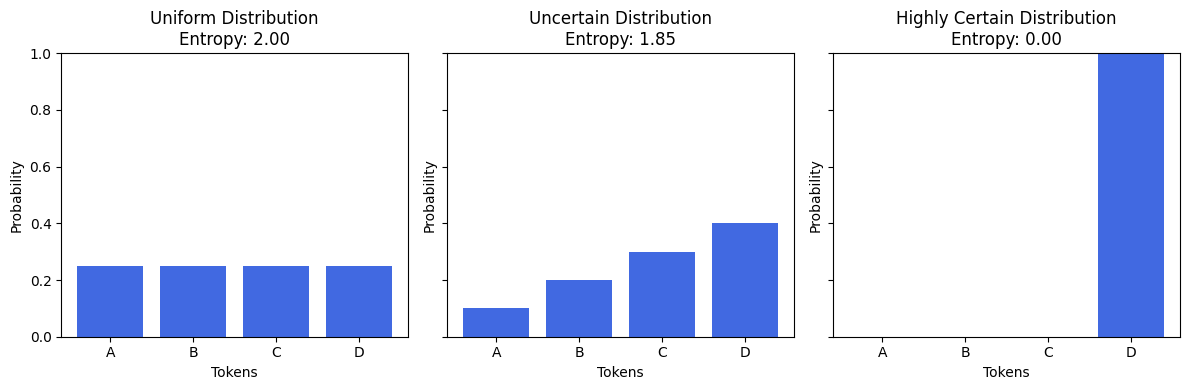

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# Define tokens
tokens = ["A", "B", "C", "D"]

# Define three probability distributions
uniform = np.array([0.25, 0.25, 0.25, 0.25])  # Total uncertainty
uncertain = np.array([0.1, 0.2, 0.3, 0.4])   # Some certainty, but still uncertain
certain = np.array([0.0, 0.0, 0.0, 1.0])      # Full certainty

# Define a function to compute entropy manually
def manual_entropy(probs):
    return -np.sum(probs * np.log2(probs + 1e-9))  # Small constant to avoid log(0)

entropies = {
    "Uniform": compute_entropy(uniform),
    "Uncertain": compute_entropy(uncertain),
    "Certain": compute_entropy(certain)
}

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

# Define distributions and titles
distributions = [uniform, uncertain, certain]
titles = [
    f"Uniform Distribution\nEntropy: {entropies['Uniform']:.2f}",
    f"Uncertain Distribution\nEntropy: {entropies['Uncertain']:.2f}",
    f"Highly Certain Distribution\nEntropy: {entropies['Certain']:.2f}"
]

# Plot each distribution
for ax, dist, title in zip(axes, distributions, titles):
    ax.bar(tokens, dist, color='royalblue')
    ax.set_ylim(0, 1)
    ax.set_title(title)
    ax.set_xlabel("Tokens")
    ax.set_ylabel("Probability")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


* The rightmost distribution represents full certainty: the model is confident that the `D` is the right answer.
* The central distribution favors `D` but considers other options as likely. This situation is problematic. It might indicate a potential error or even a hallucination.
* The leftmost distribution reflects total uncertainty—the model has no clear preference and does not know what to choose.

With probabilities, uncertainty is often assessed using **entropy**. If an LLM predicts probabilities $p = (p_1,\ldots,p_V)$ for tokens $x_1,\ldots,x_V$ from the vocabulary, entropy is calculated as:

$$entropy(p) = -\sum_{i=1}^Vp_i\log{p_i}$$

It's non-negative. If the LLM predicts a single token with 100% certainty, the entropy is 0. Otherwise, the larger the entropy is, the closer is the distribution to uniform (leftmost picture) and terminal uncertainty. Above each picture, you can check its entropy values.

When using an API, we unfortunately cannot directly calculate entropy because the API only provides the top 5 log probabilities. However, we can still infer uncertainty by:

* Checking the highest probability: If it is close to 1, the uncertainty is low.
* Comparing the top-5 probabilities: If the highest probability significantly outweighs the others—like in the leftmost picture below—the model is confident in its choice.

<center>
<img src="https://drive.google.com/uc?export=view&id=12k5EFzMZAcHntuJZBZwbm6NKqJZ1OF3l" width=600 />
</center>

Your task will be to explore the connection between uncertainty and in-context hallucination. The term "In-context hallucinations" refers to situations when an LLM’s answers are unfaithful to the context provided in a prompt.

To illustrate this, let's create a synthetic context—a list of fictional rulers along with their years of reign. Then, we'll ask the LLM to provide the years of reign for one of them.

In [ ]:
import random

def int_to_roman(num):
    val = [
        1000, 900, 500, 400,
        100, 90, 50, 40,
        10, 9, 5, 4,
        1
    ]
    syb = [
        "M", "CM", "D", "CD",
        "C", "XC", "L", "XL",
        "X", "IX", "V", "IV",
        "I"
    ]
    roman_num = ''
    i = 0
    while num > 0:
        for _ in range(num // val[i]):
            roman_num += syb[i]
            num -= val[i]
        i += 1
    return roman_num

def generate_monarchs(start_year=793, n_monarchs=100):
    names = [
        "Vaelith", "Eldric", "Seraphis", "Altheryn", "Ysara", "Thalion", "Miren", "Zephiron", "Caldris", "Velmora",
        "Eryndor", "Sylvara", "Draethor", "Ilvanya", "Tareth", "Lyssandre", "Veylan", "Morveth", "Xandrel", "Lyra"
    ]

    numerics = {name: 0 for name in names}  # Track numerics for each name
    year = start_year

    just_had_interregnum = False

    monarch_list = []

    for _ in range(n_monarchs):

        name = random.choice(names)
        numerics[name] += 1
        reign_length = random.randint(7, 20)  # Random reign length
        monarch_list.append(f"{name} {int_to_roman(numerics[name])}, {year}-{year + reign_length}")
        year += reign_length
        just_had_interregnum = False

    return(monarch_list)


In [ ]:
monarch_list = generate_monarchs(n_monarchs=2500)

In [ ]:
monarch_list[-10:]

['Velmora CXXIII, 34610-34628',
 'Veylan CXXIX, 34628-34636',
 'Eryndor CXX, 34636-34654',
 'Altheryn CXXIV, 34654-34668',
 'Lyra CXXII, 34668-34685',
 'Lyra CXXIII, 34685-34704',
 'Vaelith CXVI, 34704-34715',
 'Caldris CXVIII, 34715-34725',
 'Xandrel CXXI, 34725-34745',
 'Seraphis CXXVII, 34745-34753']

For a list of 1000 rulers, **Llama-3.1-8B** will be quite good at answering our questions (try this!). But when the list has 5000 entries, things get worse.

Create a random sample of 10 rulers (not 10 first ones and not 10 last ones; please take a random subsample; otherwise you may get different and better results than you're suuposed to). Run `answer_with_logprobs` with `temperature=0.6` and the prompt

```
monarch_prompt = "Below is the list of monarchs of the land of Xu and their years of reign.\n"

monarch_prompt += "\n".join(monarch_list)

monarch_prompt += """\nUsing this list, give the years of reign of {test_monarch}.
Only give the years in the format <start_year>-<end_year>"""
```

Print logprobs using `logprobs_to_table` for several correct and several incorrect answers. If there are no correct answers, rerun the experiment and/or increase the test sample. Investigate the table. Is the LLM more confident when given correct answers?

In [ ]:
# <YOUR EXPERIMENTS HERE>

**Solution**

Let's tun the experiment

In [ ]:
import numpy as np

test_cases = np.random.choice(monarch_list, size=10, replace=False)
test_cases

array(['Draethor XLIII, 11872-11887', 'Sylvara CV, 30221-30233',
       'Lyssandre XXIII, 6446-6460', 'Thalion LVIII, 15364-15372',
       'Ilvanya XXXIV, 9903-9911', 'Thalion CII, 26079-26096',
       'Thalion XLIII, 10518-10534', 'Lyra XXXIV, 10193-10201',
       'Eryndor XCVI, 26408-26424', 'Sylvara XII, 4419-4428'],
      dtype='<U31')

In [ ]:
monarch_prompt = "Below is the list of monarchs of the land of Xu and their years of reign.\n"

monarch_prompt += "\n".join(monarch_list)

monarch_prompt += """\nUsing this list, give the years of reign of {test_monarch}.
Only give the years in the format <start_year>-<end_year>"""

results = []

for i, test_case in enumerate(test_cases):
    test_monarch, test_years = test_case.split(", ")
    print(f"Test case no. {i}: {test_monarch}")
    result = answer_with_logprobs(
        monarch_prompt.format(test_monarch=test_monarch),
                         model="meta-llama/Meta-Llama-3.1-8B-Instruct")
    predicted_years = result.choices[0].message.content.strip()
    results.append(result)
    print(f"""True years: {test_years},\t Predicted years: {predicted_years}\t {
        "Correct" if test_years == predicted_years else "Incorrect"
    }""")

Test case no. 0: Draethor XLIII
True years: 11872-11887,	 Predicted years: 11872-11887	 Correct
Test case no. 1: Sylvara CV
True years: 30221-30233,	 Predicted years: No information is provided in the list regarding Sylvara CV.	 Incorrect
Test case no. 2: Lyssandre XXIII
True years: 6446-6460,	 Predicted years: There is no Lyssandre XXIII in the list.	 Incorrect
Test case no. 3: Thalion LVIII
True years: 15364-15372,	 Predicted years: Thalion LVIII reigned from 16736-16755.	 Incorrect
Test case no. 4: Ilvanya XXXIV
True years: 9903-9911,	 Predicted years: 9903-9911	 Correct
Test case no. 5: Thalion CII
True years: 26079-26096,	 Predicted years: 2088-2106	 Incorrect
Test case no. 6: Thalion XLIII
True years: 10518-10534,	 Predicted years: Unfortunately, Thalion XLIII is not present in the list.	 Incorrect
Test case no. 7: Lyra XXXIV
True years: 10193-10201,	 Predicted years: 5224-5243	 Incorrect
Test case no. 8: Eryndor XCVI
True years: 26408-26424,	 Predicted years: There is no Eryndor

As you see, there are a few correct options, though mostly Llama fails. Let's look at the log probabilities:

In [ ]:
logprobs_to_table(results[9].choices[0].logprobs.content)

,gen_token,gen_logp,0_token,0_logp,1_token,1_logp,2_token,2_logp,3_token,3_logp
0,441,-3.690039e-04,S,-8.202159,442,-10.415339,The,-10.597602,There,-10.962125
1,9,-1.192093e-07,8,-15.648495,7,-20.152969,6,-20.439381,5,-21.298615
2,-,-2.384186e-07,–,-15.388123,-,-16.273396,is,-17.783566,was,-21.350693
3,442,0.000000e+00,443,-17.314888,441,-19.397882,444,-21.376728,422,-21.480877
4,8,0.000000e+00,9,-17.679415,7,-19.866558,6,-20.309195,3,-21.025225
5,,-8.013613e-04,.,-7.135056,\n\n,-12.681028,\n\n,-14.126106,is,-15.141565


The 9th example is the one where Llama answered correctly, and you can see that the log probabilities of the predicted tokens (the first column) are almost zero. So, the actual probabilities are almost `exp(0) = 1`, and they dominate the distribution. So, the LLM is quite sure of its answers.

In [ ]:
logprobs_to_table(results[5].choices[0].logprobs.content)

,gen_token,gen_logp,0_token,0_logp,1_token,1_logp,2_token,2_logp,3_token,3_logp
0,208,-6.196098e+00,There,-0.467863,I,-1.691623,Unfortunately,-3.540281,261,-3.670467
1,8,-1.080772e-01,9,-2.946155,6,-4.404250,1,-4.560477,0,-4.638587
2,-,-1.072883e-06,is,-14.372661,,-15.062654,was,-16.169245,-,-16.338488
3,210,-3.457063e-06,209,-12.654196,211,-15.205864,206,-19.957695,216,-20.895042
4,6,-1.192093e-07,7,-15.986984,5,-18.460539,8,-19.371849,,-19.528072
5,,-1.975103e-04,.,-8.670661,\n\n,-11.534778,is,-11.704021,\n\n,-11.951377


On the contrary, the 5-th example is a fail, and here the log probability of the first predicted token `208` is around $-6$. It's actually surprising it was generated, and it's definitely an in-context hallucination. If we look at the tokens with top probabilities in the first row, we'll observe that:

1. They are `"There"`,  `"I"`, and `"Unfortunately"`, which would likely be continued as an apology or a statement that there's no such ruler in the list.
2. Their log probabilities start at $-0.47$ which is not so close to zero. So, the LLM isn't certain in its generation here.